In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F
from BcomMEG import *
from MEGDataset_Conv import *
from ConvNet import *
import matplotlib.pyplot as plt


In [2]:
# So one option would be to use ResNet as the pretrained and try to fine-tune it. 
# I'm not opposed to this, but it would require messing with the first layer, and
# making sort of arbitrary downscaling of the MEG data. We would have to be clever
# about this. I think I'm just going to try to train my own for right now and see
# how it goes
# resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
# print(resnet.conv1)

In [2]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
dir1 = '/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample'
subjects = ['BCOM_18_2']
picks = None

data = BcomMEG(dir=dir, subjects=subjects, picks=picks, avoid_reading=True)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_re_144-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_116-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_a_112-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
16 matching events found
No baseline correct

In [5]:
data.data

{'BCOM_18_2': {'re_144': array([[[-8.55428399e-14,  3.49952069e-14, -1.21865002e-13, ...,
           -2.25307749e-14, -2.44080184e-14, -5.97708189e-14],
          [-1.42737886e-13,  2.00048294e-14, -1.28674306e-13, ...,
            4.07094673e-14,  6.18516807e-14,  1.92329198e-14],
          [-1.03673587e-13, -1.39558219e-13, -3.94384124e-13, ...,
           -4.72346669e-14,  1.01839273e-13,  1.16277525e-13],
          ...,
          [ 2.99944341e-13,  4.01809526e-13,  4.76941132e-13, ...,
            5.69713615e-14, -1.09433506e-13,  1.95634511e-13],
          [ 6.22636870e-13,  6.96446806e-13,  8.16198292e-13, ...,
            2.88575479e-13,  7.04944255e-14,  4.18329488e-13],
          [ 7.48760917e-13,  8.06787742e-13,  9.70948582e-13, ...,
            3.88129470e-13,  2.40815207e-13,  5.18871404e-13]],
  
         [[-1.90201316e-13, -2.17420727e-13, -2.91517868e-13, ...,
            2.33402653e-13,  2.16885253e-13,  2.94684687e-13],
          [-8.95363089e-14, -1.72476088e-13, -2.

In [4]:
dataset = MEGDataset_Conv(data, label_map='multi_class_covert')

In [11]:
# Since its a linear transformation, im gunna pray this is fine lol. Its just to avoid weird rounding errors during optimization
dataset.data = dataset.data * 1e13

In [12]:
from torch.utils.data import DataLoader
data_loader = DataLoader(
    dataset, 
    batch_size=4, 
    shuffle=True,
)

for batch_index, (data, labels) in enumerate(data_loader):
    print(f"Batch {batch_index}:")
    print(f"  Data shape: {data.shape}")
    print(f"  Labels shape: {labels.shape}")
    break

Batch 0:
  Data shape: torch.Size([4, 1, 247, 241])
  Labels shape: torch.Size([4])


In [ ]:
device = 'mps'
model = ConvNet().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs = 10

n_total_steps = len(data_loader)

loss_values = []
for epoch in range(epochs):
    for i, (data, labels) in enumerate(data_loader):
        labels = labels.to(device)
        # print(data)

        outputs = model(data)
        # print(f"Outputs: {outputs}")
        # print(f"Labels: {labels}")
        loss = criterion(outputs, labels)
        print(f"Loss: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

        if (i+1) % 200 == 0:  # Adjusted the condition to a smaller number
            print(f'Epoch [{epoch + 1} / {epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Training Finished')



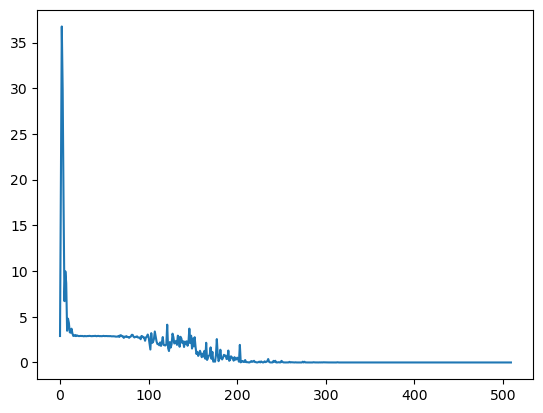

In [64]:
plt.plot(range(len(loss_values)), loss_values)

In [65]:
loss_values[-1]

0.0007938735652714968